In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [24]:
df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [25]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [26]:
df.shape

(50000, 2)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# **Data Preprocessing**

In [28]:
# Change sentiments to 0 or 1
# Either use lambda function or sklearn LabelEncoder
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [29]:
# Data after Encoding
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [30]:
# Unprocessed Data
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [31]:
# As the review contains <br> tags, we need to remove them
# The default Standardizer in TextVectorization Layer doesn't remove the <br> tags
# Therefore, a custom standardizer is needed

import re, string

def custom_standardization(input_data):
    # Convert review strings to lower case
    lowercase = tf.strings.lower(input_data)
    
    # Remove <br> tags
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

In [32]:
# Standardized string reviews
standardized_str_exp1 = custom_standardization(df['review'][1])
standardized_str_exp1

<tf.Tensor: shape=(), dtype=string, numpy=b'a wonderful little production   the filming technique is very unassuming very oldtimebbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece   the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life   the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done'>

In [33]:
# Model constants
max_features = 20000
embedding_dim = 128
sequence_length = 500

In [34]:
from tensorflow.keras.layers import TextVectorization

vectorizer_layer = TextVectorization(
    max_tokens = max_features, # Number of maximum tokens
    standardize = custom_standardization, # Standardizer function to remove <br> tags
    output_mode="int", # Output as a sequence of integers
    output_sequence_length=sequence_length # Length of output sequence
)

In [35]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['review'],df['sentiment'],test_size=0.2,random_state=42,stratify=df['sentiment'])

In [36]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000,)
(10000,)
(40000,)
(10000,)


In [37]:
# Create text only dataset without label to build vocabulary

vectorizer_layer.adapt(x_train)

In [38]:
# Use get_vocabulary() method to get the vocab
vocab = vectorizer_layer.get_vocabulary()
len(vocab)

20000

In [39]:
# Simple encoding and decoding example
test_str = "the actors are extremely well chosen michael sheen" # This is from review[1]
encoded_sentence = vectorizer_layer(test_str) # Note: string is padded with 0 to a length of 500 as sequence length is 500
print(encoded_sentence)

inverse_vocab = dict(enumerate(vocab))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

tf.Tensor(
[   2  148   23  561   70 2240  493 4514    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

# **Create Model**

In [40]:
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(None,), dtype=tf.string)
x = vectorizer_layer(inputs)
x = layers.Embedding(input_dim=max_features, output_dim=embedding_dim)(x)
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs,outputs)

In [41]:
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])

In [42]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 128)          2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,601,281
Trainable params: 2,601,281
Non-trainable params: 0
_________________________________________________

**Using ModelCheckpoint Callbacks results in error when saving as TextVectorization Layer is not supported**

In [49]:
# Callbacks to save best model
callbacks = [tf.keras.callbacks.ModelCheckpoint("embedding_lstm.keras", save_best_only=True)]

In [51]:
history = model.fit(x_train,y_train,batch_size=32,epochs=10,validation_split=0.2)

Epoch 1/10
1000/1000 [==============================] - 44s 44ms/step - loss: 0.1844 - accuracy: 0.9350 - val_loss: 0.2868 - val_accuracy: 0.8829
Epoch 2/10
1000/1000 [==============================] - 43s 43ms/step - loss: 0.1620 - accuracy: 0.9430 - val_loss: 0.2746 - val_accuracy: 0.9013
Epoch 3/10
1000/1000 [==============================] - 43s 43ms/step - loss: 0.1401 - accuracy: 0.9510 - val_loss: 0.3101 - val_accuracy: 0.8879
Epoch 4/10
1000/1000 [==============================] - 43s 43ms/step - loss: 0.1191 - accuracy: 0.9595 - val_loss: 0.3343 - val_accuracy: 0.8929
Epoch 5/10
1000/1000 [==============================] - 44s 44ms/step - loss: 0.1078 - accuracy: 0.9639 - val_loss: 0.3335 - val_accuracy: 0.8888
Epoch 6/10
1000/1000 [==============================] - 45s 45ms/step - loss: 0.0948 - accuracy: 0.9685 - val_loss: 0.3606 - val_accuracy: 0.8852
Epoch 7/10
1000/1000 [==============================] - 45s 45ms/step - loss: 0.0830 - accuracy: 0.9734 - val_loss: 0.3802 -

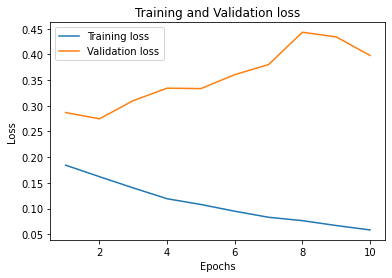

In [55]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, 11)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

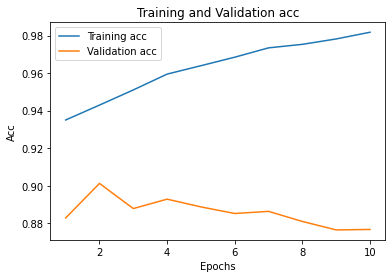

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, 11)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# **Evaluation**

In [57]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 7s 19ms/step - loss: 0.4159 - accuracy: 0.8742


[0.4158768057823181, 0.8741999864578247]

In [58]:
y_pred = model.predict(x_test)

In [68]:
y_pred = (y_pred >= 0.5).astype(int)

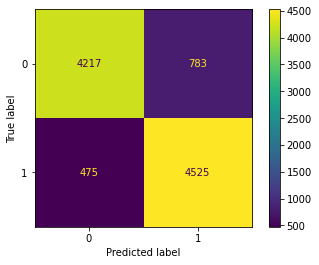

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [74]:
model.save("lstm_embedding_model",save_format="tf")

In [76]:
loaded_model = tf.keras.models.load_model('./embedding_lstm.keras')

ValueError: The standardize argument of layer TextVectorization received an invalid value custom_standardization. Allowed values are: `None`, a `Callable`, or one of the following values: lower_and_strip_punctuation.